In [1]:
# Import libraries
import pandas as pd              
import numpy as np                   
import matplotlib.pyplot as plt      
import seaborn as sns                
from matplotlib.colors import LinearSegmentedColormap 
from sklearn.model_selection import train_test_split  
from tensorflow.keras import layers, models  
import ast                            
import warnings                       

# Set the style and color palette for Seaborn visualizations
palette = ['#f28a30', '#3b94d9', '#e0c72c', '#6a4d8e', '#e63946', '#2a9d8f', '#264653']
sns.set_theme(context='notebook', palette=palette, style='darkgrid')

# Suppress specific FutureWarning messages to clean up output
warnings.simplefilter(action='ignore', category=FutureWarning)

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

<div style="background-color: pink; color: black; padding: 10px; border-radius: 10px; font-size: 24px;">
  Data Cleaning and Data Merging
</div>

Step 1: Reading Data. Let's begin by reading in two CSV files: one containing movie metadata (movies_metadata.csv) and another with user ratings (ratings_small.csv). These files form the foundation of our recommendation system.

Step 2: Cleaning the Movies Data. The id column in the movies dataset needs to be numeric for the merging process later. We'll convert this column to a numeric format, handling any errors by replacing invalid entries with NaN values. Rows with missing values in the id column are then dropped to ensure a clean dataset.

Step 3: Merging Datasets. To combine user ratings with movie metadata, we merge the ratings dataset with the cleaned movies dataset using the movieId and id columns. This produces a unified dataset containing both user rating information and movie details.

In [2]:
# Define file paths for the datasets
movies_metadata_path = '/kaggle/input/the-movies-dataset/movies_metadata.csv'
ratings_small_path = '/kaggle/input/the-movies-dataset/ratings_small.csv'

# Read the CSV files containing movie metadata and user ratings
movies = pd.read_csv(movies_metadata_path, low_memory=False)
ratings = pd.read_csv(ratings_small_path)

# Clean up the 'id' column in the movies dataframe
movies['id'] = pd.to_numeric(movies['id'], errors='coerce')  # 'coerce' turns invalid parsing into NaN

# Drop rows where 'id' is NaN (i.e., rows with invalid IDs)
movies.dropna(subset=['id'], inplace=True)

# Merge the movies and ratings datasets on 'id' (movies) and 'movieId' (ratings)
merged_data = pd.merge(ratings, movies, left_on='movieId', right_on='id', how='inner')

<div style="background-color: pink; color: black; padding: 10px; border-radius: 10px; font-size: 24px;">
  Data Preprocessing and Feature Engineering
</div>


Step 4: Feature Engineering. Let's create two new features:
is_in_collection: A boolean indicating whether the movie belongs to a collection.
release_year: This is extracted from the movie's release date to help with analysis and modeling.

Step 5: Selecting Relevant Columns. We ill retain only the essential columns for our recommendation model, such as user ID, movie ID, rating, genre information, budget, runtime, release year, etc.

Step 6: Processing Genres. The genre data is initially stored as a list of dictionaries. First, we will fill missing genre data with empty lists. Then, using Python's ast module, we'll convert these string representations into actual Python lists.

Step 7: Extracting Genre Names. From the list of dictionaries, let's extract the genre names and store them in a new column called genre_names. This makes the genre data more accessible for further processing.

Step 8: One-Hot Encoding Genres. Since genre information is categorical, we'll perform one-hot encoding to convert genre names into binary columns. This step allows us to use genres as input features for our recommendation model.

Step 9: Dropping Unnecessary Columns. After one-hot encoding, the original genres and genre_names columns are no longer needed, so they are dropped from the dataset.

In [3]:
# Feature Engineering
# Adding a feature to check if the movie belongs to a collection or not (binary feature)
merged_data['is_in_collection'] = merged_data['belongs_to_collection'].notnull()

# Filter the data to include only movies that were officially released
merged_data = merged_data[merged_data['status'] == 'Released']

# Extract the year from the release date to create a 'release_year' feature
merged_data['release_year'] = pd.to_datetime(merged_data['release_date']).dt.year

# Select relevant columns for the recommendation system and further processing
merged_data = merged_data[['userId', 'movieId', 'rating', 'genres', 'timestamp', 'budget', 'imdb_id', 
                           'original_language', 'popularity', 'revenue', 'runtime', 'title', 
                           'vote_average', 'vote_count', 'is_in_collection', 'release_year']]

# Genre processing
# Fill missing 'genres' with an empty list ('[]') and convert genre strings to a list of dictionaries
merged_data['genres'] = merged_data['genres'].fillna('[]')
merged_data['genres'] = merged_data['genres'].apply(ast.literal_eval)

# Extract the genre names from the dictionaries
merged_data['genre_names'] = merged_data['genres'].apply(lambda x: [d['name'] for d in x])

# One-hot encoding the genres
# Convert the list of genres into a one-hot encoded dataframe (binary columns for each genre)
genre_dummies = merged_data['genre_names'].str.join('|').str.get_dummies()

# Concatenate the original dataframe with the one-hot encoded genres
merged_data = pd.concat([merged_data, genre_dummies], axis=1)

# Drop the original 'genres' and 'genre_names' columns as they are no longer needed
merged_data.drop(['genres', 'genre_names'], axis=1, inplace=True)

# Check the shape of the processed dataset
print(f"Shape of merged dataset: {merged_data.shape}")

Shape of merged dataset: (44939, 35)


<div style="background-color: pink; color: black; padding: 10px; border-radius: 10px; font-size: 24px;">
  Exploratory Data Analysis
</div>

### Movie Genre Distribution

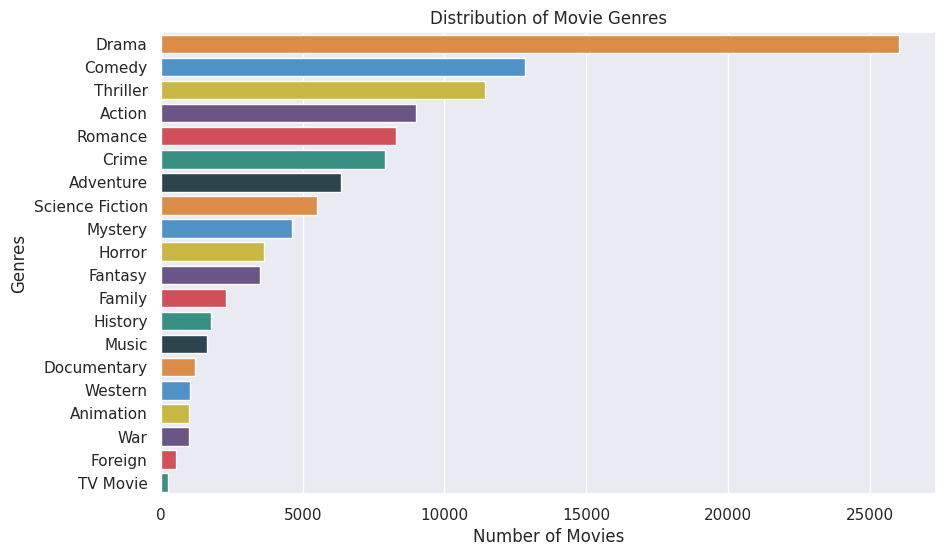

In [4]:
genre_counts = genre_dummies.sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette=palette)
plt.title('Distribution of Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genres')
plt.show()

### User Rating Distribution

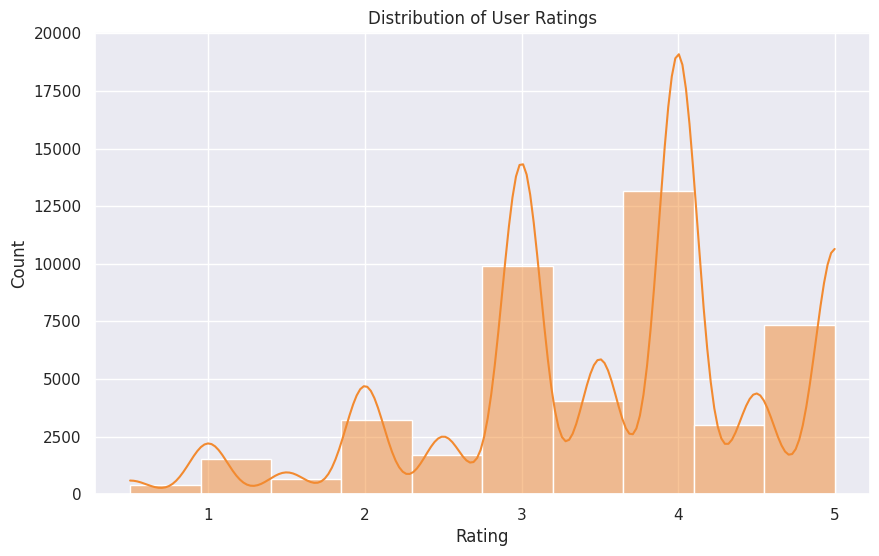

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['rating'], bins=10, kde=True, color=palette[0])
plt.title('Distribution of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### Heatmap of Correlations Between Movie Attributes

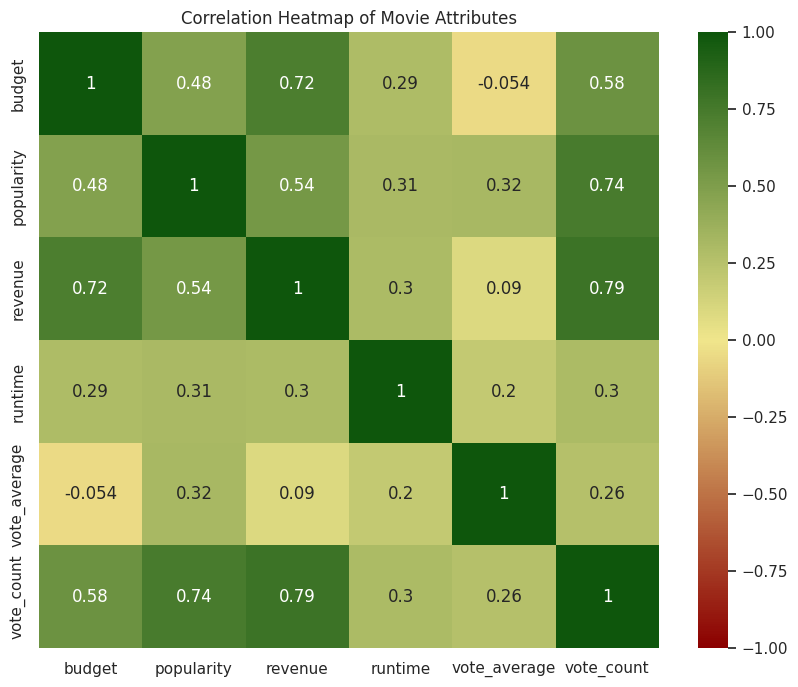

In [6]:
# Define the custom colormap
colors = ['#8B0000', '#f0e68c', '#0e560c']
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

numeric_features = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
correlation_matrix = merged_data[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Movie Attributes')
plt.show()

## Credit:


https://www.kaggle.com/code/annastasy/movie-magic-data-driven-recommendations/notebook